In [29]:
# conda install pytorch
# conda install torchvision

# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection  
from sklearn.metrics import confusion_matrix 
# import tqdm
import torch
import torch.nn as nn
# import torchvision
from torchvision import transforms
# import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import torchvision.models as models
# import torchvision.transforms.functional as fn
from torch.autograd import Variable
# import cv2
from sklearn.metrics import accuracy_score
import sys
# import os
# import gc
import pickle

In [30]:
# LOAD BASE DATA (only once)
print("Loading data... ",end='',flush=True)
BASE_DATA = np.load("Data/All2/data_150_gray.npy")
BASE_LABELS = np.load("Data/All2/labels.npy")
print("Done!")
print("Size of BASE_DATA:",sys.getsizeof(BASE_DATA))
print("Size of BASE_LABELS:",sys.getsizeof(BASE_LABELS))

retrainModel = True
modelFilePath = "Params_All2_1.pkl"

n_epochs = 200
mod_epoch = 4

Loading data... Done!
Size of BASE_DATA: 27112628
Size of BASE_LABELS: 1317


In [31]:
figsize = 150
batch_size = 64
dataImages = BASE_DATA
labels = BASE_LABELS

datatrain, dataval, labeltrain, labelval = model_selection.train_test_split(dataImages, labels, test_size=0.2, shuffle=True, random_state=8)

dataval, datatest, labelval, labeltest = model_selection.train_test_split(dataval, labelval, test_size=0.33, shuffle=True, random_state=6)

datatrain= datatrain.reshape(datatrain.shape[0], 1, figsize, figsize)
datatrain = torch.from_numpy(datatrain)
labeltrain = labeltrain.astype(int)
labeltrain = torch.from_numpy(labeltrain)

dataval= dataval.reshape(dataval.shape[0], 1, figsize, figsize)
dataval = torch.from_numpy(dataval)
labelval = labelval.astype(int)
labelval = torch.from_numpy(labelval)

datatest= datatest.reshape(datatest.shape[0], 1, figsize, figsize)
datatest = torch.from_numpy(datatest)
labeltest = labeltest.astype(int)
labeltest = torch.from_numpy(labeltest)

print("datatrain.shape:\t",datatrain.shape)
print("dataval.shape:\t\t",dataval.shape)
print("datatest.shape:\t\t",datatest.shape)

datatrain.shape:	 torch.Size([964, 1, 150, 150])
dataval.shape:		 torch.Size([161, 1, 150, 150])
datatest.shape:		 torch.Size([80, 1, 150, 150])


In [32]:
class MyData(Dataset):
        def __init__(self, X, t, transform=None):
            self.X = X.float()
            self.t = t.long()
            self.transform = transform

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            X = self.X[idx]
            t = self.t[idx]
            if self.transform:
                X = self.transform(X)
            return X, t

train_aug = transforms.Compose([
        # transforms.ToPILImage(),
        # transforms.ColorJitter(brightness=.05, contrast=.05),
        transforms.RandomRotation(degrees=(-180,180)),
        # transforms.RandomResizedCrop(figsize),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.GaussianBlur(kernel_size=(3,3)),
        # transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
val_aug = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.GaussianBlur(kernel_size=(3,3)),
        # transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
test_aug = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.GaussianBlur(kernel_size=(3,3)),
        # transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
    
    
train_data = MyData(datatrain,labeltrain,transform=train_aug)
# train_data = MyData(datatrain,labeltrain)

val_data = MyData(dataval,labelval,transform=val_aug)
# val_data = MyData(dataval,labelval)

test_data = MyData(datatest,labeltest,transform=test_aug)
# test_data = MyData(datatest,labeltest)

train_load = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=False)
val_load = DataLoader(dataset=val_data,batch_size=batch_size,shuffle=False)
test_load = DataLoader(dataset=test_data,batch_size = batch_size, shuffle=False)

In [33]:
class CNN(nn.Module):
        def __init__(self):
            super(CNN,self).__init__()

            # CNN Block = Conv Layer, Batch Norm, MaxPool layer, ReLU activation
            self.cnn_layers = nn.Sequential(
                # First CNN block
                nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=1, padding=0),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2),
                
                # Second CNN block
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1, padding=0),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2),
                
                # Third CNN block
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2),
                
                # Fourth CNN block
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1, padding=0),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2),
                
                # Fifth CNN block
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1, padding=0),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2),
            )

            # Linear layers
            self.linear_layers = nn.Sequential(
                nn.Linear(in_features=1152, out_features=512),
                nn.Linear(in_features=512, out_features=256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout2d(0.2),
                nn.Linear(in_features=256,out_features=3),
                nn.LogSoftmax(dim=1)
            )
        
        def forward(self, x):
            x = self.cnn_layers(x)
            x = x.view(x.size(0), -1)
            x = self.linear_layers(x)
            return x

In [34]:
model = CNN()

train_losses = []
val_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.NLLLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = nn.DataParallel(model)
# model.to(device)

print(model)

# print("Size of model:",sys.getsizeof(model)) # = 48
# print("Size of optimizer:",sys.getsizeof(optimizer)) # = 48
# print("Size of criterion:",sys.getsizeof(criterion)) # = 48

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, paddi

In [35]:
def train(epoch, validate):
    for batches, (images, labels) in enumerate(train_load):
        model.train()
        tr_loss = 0
    
        traindata, trainlabel = Variable(images), Variable(labels)
        #
    
        if torch.cuda.is_available():
            traindata = traindata.cuda()
            trainlabel = trainlabel.cuda()
            #valdata = valdata.cuda()
            #vallabel = vallabel.cuda()
        
        optimizer.zero_grad()
    
        traindata = traindata.float()
        #valdata = valdata.float()

        # print(traindata.shape)
    
        output_train = model(traindata)
        #output_val = model(valdata)
    
        loss_train = criterion(output_train, trainlabel)
        #loss_val = criterion(output_val, vallabel)
    
        
        #val_losses.append(loss_val)
    
        loss_train.backward()
        optimizer.step()
    if validate:
        for batches, (images, labels) in enumerate(val_load):
                valdata, vallabel = Variable(images), Variable(labels)
                if torch.cuda.is_available():
                    #traindata = traindata.cuda()
                    #trainlabel = trainlabel.cuda()
                    valdata = valdata.cuda()
                    vallabel = vallabel.cuda()
                valdata = valdata.float()
                output_val = model(valdata)
                loss_val = criterion(output_val, vallabel)
        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())

In [36]:
# print("\tmax_memory_allocated:\t",torch.cuda.max_memory_allocated(), sep='')
# print("\tmemory_allocated:\t",torch.cuda.memory_allocated(), sep='')
# print("\tmax_memory_reserved:\t",torch.cuda.max_memory_reserved(), sep='')
# print("\tmemory_reserved:\t",torch.cuda.memory_reserved(), sep='')

# torch.cuda.empty_cache()

# print("\tmax_memory_allocated:\t",torch.cuda.max_memory_allocated(), sep='')
# print("\tmemory_allocated:\t",torch.cuda.memory_allocated(), sep='')
# print("\tmax_memory_reserved:\t",torch.cuda.max_memory_reserved(), sep='')
# print("\tmemory_reserved:\t",torch.cuda.memory_reserved(), sep='')

In [37]:
# testMode should be 1 of the following: "train", "val", "test"
def calculateAccuracy(testModel, testMode, printOutput=False):
    testModel.eval()
    tempLoader = None
    tempLabels = None
    if testMode == "train":
        tempLoader = train_load
        tempLabels = labeltrain
    elif testMode == "val":
        tempLoader = val_load
        tempLabels = labelval
    elif testMode == "test":
        tempLoader = test_load
        tempLabels = labeltest
    else:
        print("Invalid testMode given (", str(testMode), ")", sep='')
        return -1
        
    output = np.empty([0, 3])
    with torch.no_grad():
        for batches, (images, labels) in enumerate(tempLoader):
            # output_tensor = testModel(images.cuda().float())
            output_tensor = testModel(images)
            output = np.vstack((output, torch.as_tensor(output_tensor).cpu().numpy()))
    
    predictions = np.argmax(output, axis = 1)

    accuracy = accuracy_score(tempLabels, predictions)

    if printOutput:
        print("testMode:", testMode)
        print("\tAccuracy Score:", round(accuracy,4))
        print("\tConfusion Matrix:")
        print(confusion_matrix(tempLabels, predictions))
        print()
    
    testModel.train()
    return accuracy

In [38]:
if retrainModel:
    # Train model

    for epoch in range(n_epochs):
        train(epoch, epoch % mod_epoch == 0)

        loss_train = train_losses[-1] # Get last element in list

        msg = "Epoch: " + str(epoch)
        msg += "\tLoss: " + np.format_float_scientific(loss_train, precision=3)
        msg += "\tMemory Allocated: " + np.format_float_scientific(torch.cuda.memory_allocated(), precision=3)

        if False:
            trainAccuracy = calculateAccuracy(model, "train")
            valAccuracy = calculateAccuracy(model, "val")
            testAccuracy = calculateAccuracy(model, "test")

            msg += "\tAccuracy: Train: " + np.format_float_scientific(trainAccuracy, precision=3)
            msg += "\tVal: " + np.format_float_scientific(valAccuracy, precision=3)
            msg += "\tTest: " + np.format_float_scientific(testAccuracy, precision=3)

        if epoch % mod_epoch == 0:
            print(msg)
else:
    # Load model
    
    # LOAD MODEL PARAMETERS (only once)
    import pickle

    print("Loading model... ", end='', flush=True)
    with open(modelFilePath, "rb") as file:
        model_parameters = pickle.load(file)
    print("Done!")
    
    model = CNN()
    model.load_state_dict(model_parameters)
    
    # Define test model
    model.cuda()
    model.eval()

c:\Users\poole\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 0	Loss: 9.551e-01	Memory Allocated: 0.e+00
Epoch: 4	Loss: 9.126e-01	Memory Allocated: 0.e+00
Epoch: 8	Loss: 9.927e-01	Memory Allocated: 0.e+00
Epoch: 12	Loss: 1.015e+00	Memory Allocated: 0.e+00
Epoch: 16	Loss: 5.608e-01	Memory Allocated: 0.e+00
Epoch: 20	Loss: 7.621e-01	Memory Allocated: 0.e+00
Epoch: 24	Loss: 4.429e-01	Memory Allocated: 0.e+00
Epoch: 28	Loss: 1.008e+00	Memory Allocated: 0.e+00
Epoch: 32	Loss: 6.856e-01	Memory Allocated: 0.e+00
Epoch: 36	Loss: 5.337e-01	Memory Allocated: 0.e+00
Epoch: 40	Loss: 2.618e-01	Memory Allocated: 0.e+00
Epoch: 44	Loss: 3.292e-01	Memory Allocated: 0.e+00
Epoch: 48	Loss: 4.169e-01	Memory Allocated: 0.e+00
Epoch: 52	Loss: 6.697e-01	Memory Allocated: 0.e+00
Epoch: 56	Loss: 1.845e-01	Memory Allocated: 0.e+00
Epoch: 60	Loss: 3.256e-01	Memory Allocated: 0.e+00
Epoch: 64	Loss: 4.754e-01	Memory Allocated: 0.e+00
Epoch: 68	Loss: 3.277e-01	Memory Allocated: 0.e+00
Epoch: 72	Loss: 1.249e+00	Memory Allocated: 0.e+00
Epoch: 76	Loss: 7.245e-01	Memory A

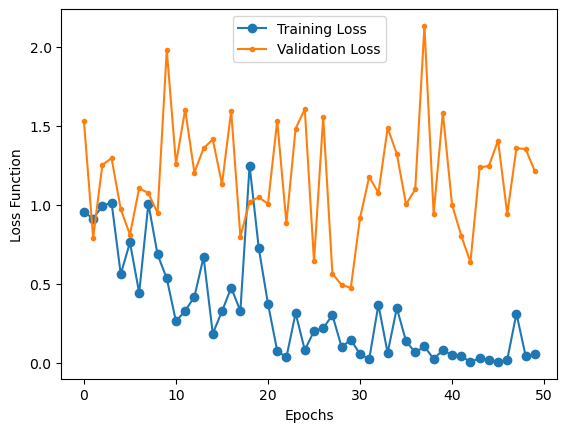

In [39]:
plt.plot(np.asarray(train_losses), label = 'Training Loss', marker = 'o')
plt.plot(np.asarray(val_losses), label = 'Validation Loss', marker = '.')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.show()

In [40]:
calculateAccuracy(model, "train", True)
calculateAccuracy(model, "val", True)

accuracies = [calculateAccuracy(model, "test", False) for i in range(10)]
print(np.mean(accuracies))

testMode: train
	Accuracy Score: 0.7967
	Confusion Matrix:
[[200   0  50]
 [ 12 181 126]
 [  8   0 387]]



c:\Users\poole\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


testMode: val
	Accuracy Score: 0.6398
	Confusion Matrix:
[[32  0  3]
 [15 10 35]
 [ 5  0 61]]



c:\Users\poole\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
c:\Users\poole\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
c:\Users\poole\anaconda3\Lib\site-packages\torch

0.7012499999999999


c:\Users\poole\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


c:\Users\poole\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


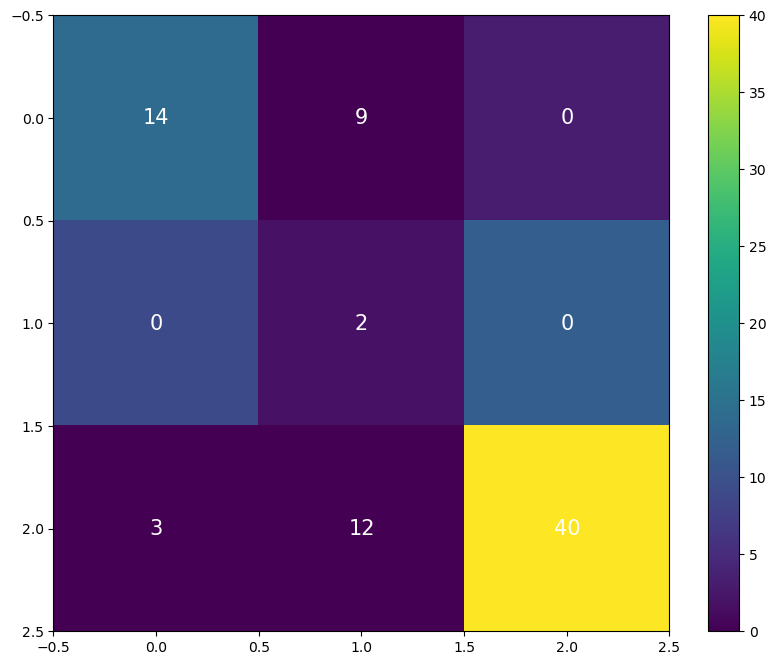

In [41]:
# Generate nice heatmap
model.eval()

output = np.empty([0, 3])
with torch.no_grad():
    for batches, (images, labels) in enumerate(test_load):
        # output_tensor = model(images.cuda().float())
        output_tensor = model(images)
        output = np.vstack((output, torch.as_tensor(output_tensor).cpu().numpy()))

predictions = np.argmax(output, axis = 1)

accuracy = accuracy_score(labeltest, predictions)

conf = confusion_matrix(labeltest, predictions)

plt.figure(figsize=(10,8))
plt.imshow(conf, cmap='viridis')
for i in range(0,3):
    for j in range(0,3):
        plt.text(i, j, str(round(conf[i,j])), horizontalalignment='center', verticalalignment='center', fontsize=15, color='white')
plt.colorbar()
# plt.savefig("Figures/TestConfusionMatrix.pdf", bbox_inches='tight')
plt.show()

In [42]:
# SAVE MODEL .pkl
saveModel = True

if saveModel:
    print("Saving model... ", end='', flush=True)
    model_parameters = model.state_dict()
    with open(modelFilePath, "wb") as file:
        pickle.dump(model_parameters, file)
    print("Done!")

Saving model... Done!
